In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

# Prepare and merge the datasets

In [103]:
# # read app_sdk/app_sdk.csv
# app_sdk = pd.read_csv('app_sdk/app_sdk.csv')
# app_sdk = app_sdk.loc[:, ~app_sdk.columns.str.contains('^Unnamed')]

In [104]:
df_google_first = pd.read_csv('app_sdk/google_data_first.csv', encoding='ISO-8859-1')
df_google_first = df_google_first.loc[:, ~df_google_first.columns.str.contains('^Unnamed')]

In [105]:
df_google_last = pd.read_csv('app_sdk/google_data_last.csv', encoding='ISO-8859-1')
df_google_last = df_google_last.loc[:, ~df_google_last.columns.str.contains('^Unnamed')]

In [106]:
# concatenate the two dataframes
df = pd.concat([df_google_first, df_google_last])

In [107]:
# drop duplicates
df = df.drop_duplicates()

# Analyze df_merged

In [108]:
def dataframe_summary(df):
    print(f"DataFrame contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
    df_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Non-null Count': df.count(),
        'Null Count': df.isnull().sum(),
        'Null Percentage (%)': (df.isnull().sum() / len(df)) * 100
    })
    print(df_info)

# Run the function to get an enhanced summary of the DataFrame
dataframe_summary(df)

DataFrame contains 1621373 rows and 27 columns.

                    Data Type  Non-null Count  Null Count  Null Percentage (%)
my_app_id              object         1621373           0             0.000000
date_published         object         1621370           3             0.000185
privacy_policy         object         1103818      517555            31.920786
rating_app            float64         1477898      143475             8.848982
nb_rating              object         1477897      143476             8.849043
num_downloads          object         1621352          21             0.001295
content_rating_app     object         1621370           3             0.000185
developer              object         1621361          12             0.000740
categ_app              object         1621361          12             0.000740
in_app                   bool         1621373           0             0.000000
has_ads                  bool         1621373           0             0.000000
pri

# Classify Apps into "Free", "Paid", "Freemium"

In [109]:
# Use columns my_app_id, num_downloads, rating_app, nb_rating.
df = df[['my_app_id', 'num_downloads', 'rating_app', 'nb_rating', 'price_gplay', 'in_app']]

In [110]:
# Drop rows where no numeric part is found (if desired)
df = df.dropna(subset=['price_gplay'])

In [111]:
# List of currency symbols and codes to match, including €
currency_codes = ["€", "£", "$", "USD", "CZK", "EUR", "RUB", "AUD", "GBP", "JPY", "CAD", "KRW", "INR", "AED", 
                  "DKK", "SAR", "PLN", "UAH", "SEK", "IDR", "TRY", "TWD", "ILS", "HKD", "BGN", "MXN", "MYR", 
                  "BRL", "CLP", "CHF", ""]

# Create a regex pattern to match the symbols and codes
currency_pattern = r'|'.join(map(re.escape, currency_codes))

df_filtered = df.copy()

# Remove currency symbols and codes
df_filtered['numeric_value'] = df_filtered['price_gplay'].apply(lambda x: re.sub(currency_pattern, '', x).strip() if isinstance(x, str) else None)

df_filtered['numeric_value'] = df_filtered['numeric_value'].str.replace(',', '.')

# remove initial-scale=1. minimum-scale " hre
df_filtered['numeric_value'] = df_filtered['numeric_value'].str.replace('initial-scale=1. minimum-scale " hre', '')

# remove empty strings
df_filtered = df_filtered[df_filtered['numeric_value'] != '']

# convert to float
df_filtered['numeric_value'] = df_filtered['numeric_value'].astype(float)

In [112]:
# Categorize apps based on 'numeric_value'
df_filtered['price_category'] = df_filtered['numeric_value'].apply(lambda x: "free" if x == 0 else "paid")

# Identify freemium apps where in_app == 1 and price_category == "free"
df_filtered['price_category'] = df_filtered.apply(lambda row: "freemium" if row['price_category'] == "free" and row['in_app'] == 1 else row['price_category'], axis=1)

# Separate paid, free, and freemium apps
paid_apps = df_filtered[df_filtered['price_category'] == "paid"]
free_apps = df_filtered[df_filtered['price_category'] == "free"]
freemium_apps = df_filtered[df_filtered['price_category'] == "freemium"]

In [113]:
df_filtered = df_filtered[['my_app_id', 'num_downloads', 'rating_app', 'nb_rating', 'price_category']]

In [114]:
df_filtered.head()

,my_app_id,num_downloads,rating_app,nb_rating,price_category
0,AOIC.AOIC_anb01,100+ >,3.0,2,paid
1,Adrenaline.Crew,"5,000+",3.7,155,paid
2,Alekseyt.Lusher,"1,000,000+",4.3,"7,539",free
3,Alfasoft.Widgets.AustriaFlagAnalogClock,10+,NaN,NaN,paid
4,Alfasoft.Widgets.CroatiaFlagAnalogClock,10+,5.0,1,paid


# Number of Downloads

In [115]:
# Function to clean and convert to numbers
def convert_to_numeric(value):
    if pd.isna(value):
        return np.nan
    else:
        # Remove ',' and '+' and '>' and strip any whitespace
        cleaned_value = value.replace(',', '').replace('+', '').replace('>', '').strip()
        return int(cleaned_value)

# Apply the function to the DataFrame column
df_filtered['num_downloads'] = df_filtered['num_downloads'].apply(convert_to_numeric)

# Ratings

In [116]:
df_filtered = df_filtered.dropna()

In [117]:
# convert 76,545 to 76545
df_filtered['nb_rating'] = df_filtered['nb_rating'].str.replace(',', '')

df_filtered['nb_rating'] = pd.to_numeric(df_filtered['nb_rating'])
df_filtered['rating_app'] = pd.to_numeric(df_filtered['rating_app'])

# Calculate the global average rating across all apps
global_mean_rating = df_filtered['rating_app'].mean()

# Define a prior weight (m)
# This is the number of ratings at which the average rating is considered reliable.
# Adjust based on your data; higher values give more weight to the global mean.
m = 50

# Calculate Bayesian average for each app
df_filtered['bayesian_average'] = (global_mean_rating * m + df_filtered['rating_app'] * df_filtered['nb_rating']) / (m + df_filtered['nb_rating'])


In [123]:
df_filtered.head()

,my_app_id,num_downloads,rating_app,nb_rating,price_category,bayesian_average
0,AOIC.AOIC_anb01,100,3.0,2,paid,4.083556
1,Adrenaline.Crew,5000,3.7,155,paid,3.804121
2,Alekseyt.Lusher,1000000,4.3,7539,free,4.298860
4,Alfasoft.Widgets.CroatiaFlagAnalogClock,10,5.0,1,paid,4.144018
10,Alfasoft.Widgets.PsychedelicAnalogClock,50000,3.9,416,free,3.924345


# Graphs

C:\Users\Kevin\AppData\Local\Temp\ipykernel_31068\2993011348.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_filtered, x='price_category', y='num_downloads', palette=palette, ci=None)
C:\Users\Kevin\AppData\Local\Temp\ipykernel_31068\2993011348.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtered, x='price_category', y='num_downloads', palette=palette, ci=None)


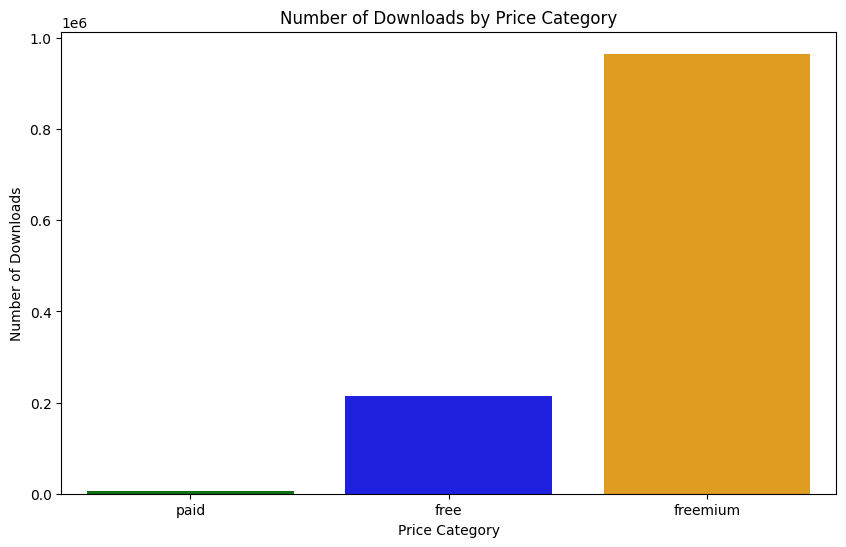

C:\Users\Kevin\AppData\Local\Temp\ipykernel_31068\2993011348.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='price_category', y='rating_app', palette=palette)


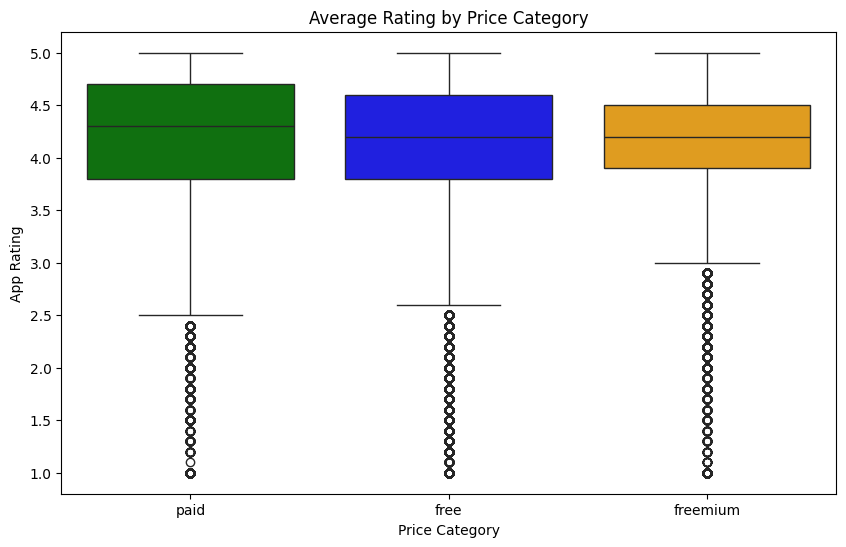

C:\Users\Kevin\AppData\Local\Temp\ipykernel_31068\2993011348.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_filtered, x='price_category', y='nb_rating', palette=palette, ci=None)
C:\Users\Kevin\AppData\Local\Temp\ipykernel_31068\2993011348.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtered, x='price_category', y='nb_rating', palette=palette, ci=None)


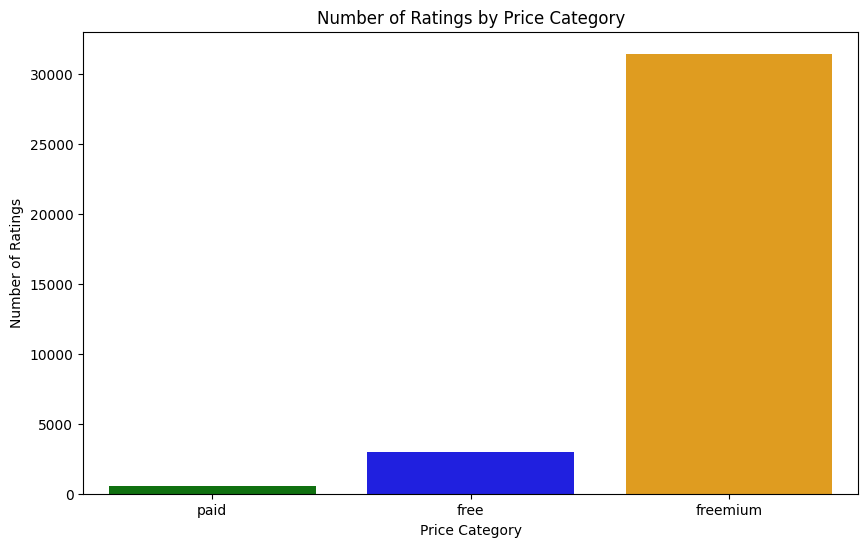

C:\Users\Kevin\AppData\Local\Temp\ipykernel_31068\2993011348.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='price_category', y='bayesian_average', palette=palette)


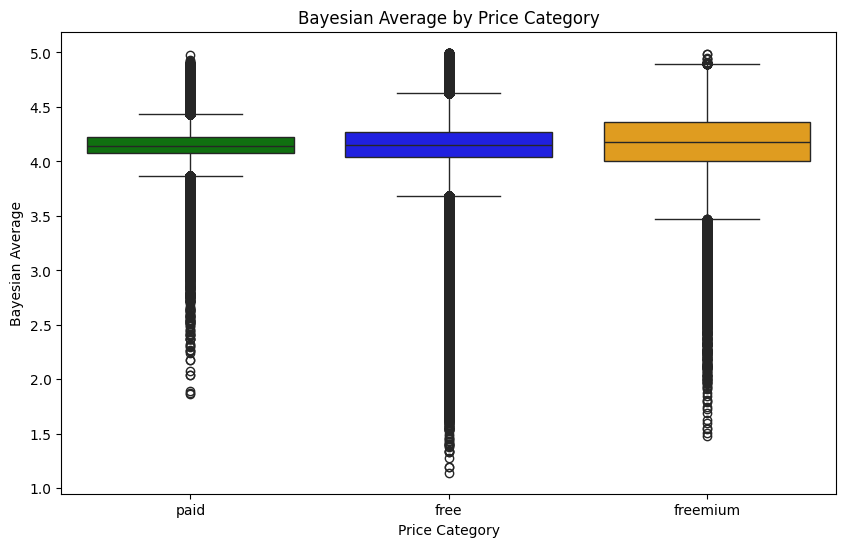

In [122]:
# Set up a color palette for price categories
palette = {"free": "blue", "paid": "green", "freemium": "orange"}

# 1. Number of Downloads by Price Category
plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x='price_category', y='num_downloads', palette=palette, ci=None)
plt.title("Number of Downloads by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Number of Downloads")
plt.show()

# 2. Average Rating by Price Category
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='price_category', y='rating_app', palette=palette)
plt.title("Average Rating by Price Category")
plt.xlabel("Price Category")
plt.ylabel("App Rating")
plt.show()

# 3. Number of Ratings by Price Category
plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x='price_category', y='nb_rating', palette=palette, ci=None)
plt.title("Number of Ratings by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Number of Ratings")
plt.show()

# 4. Bayesian Average by Price Category
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='price_category', y='bayesian_average', palette=palette)
plt.title("Bayesian Average by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Bayesian Average")
plt.show()